# LeNet

LeNet是最早的卷积神经网络之一。 LeNet-5由两部分组成：
* 卷积编码器：两个卷积层
* 全连接稠密层：三个全连接
![](./img/lenet.svg "LeNet-5")

**卷积层：**
每个卷积块由一个卷积层、一个sigmoid激活函数和一个平均池化层组成。卷积层使用 $5 \times 5$卷积核，步长均为1，池化层采用$2 \times 2$下采样，步长为2。 每个卷积层都增加输出通道数量，第一个卷积层padding为2，输出通道数为6，第二个卷积层输出通道数为16.

**全连接层：**
第二个卷积输出(四维张量 $(b \times n \times h \times w)$)展平成全连接所需要的输入向量(二维张量$(b,n \times h \times w)$)。LeNet的三个全连接输出分别为120、84、10。

![](./img/lenet-vert.svg "LeNet-5")


In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torch import nn
from IPython import display


Lenet = nn.Sequential(
    nn.Conv2d(1,6,kernel_size = 5,padding=2),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size = 5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

In [2]:
X = torch.rand(size = (1,1,28,28),dtype = torch.float32)
for layer in Lenet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


# MNIST数据集

In [3]:
# 读取Mnist数据
# ToTensor将图像数据从PIL转化成32位浮点数
# 并除以255将所有像素归一化。
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root = '../../../../AI/DataSets/',train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root = '../../../../AI/DataSets/',train=False,transform=trans,download=True)

# Mnist数据集由元组构成，元组第一维是图像数据，第二维是标签，共有60000张训练集数据，10000张测试集数据
type(mnist_train),type(mnist_train[0]),mnist_train[0][0].shape,mnist_train[0][1],len(mnist_train),len(mnist_test),mnist_train[0][0].shape,mnist_train[0][1]


(torchvision.datasets.mnist.FashionMNIST,
 tuple,
 torch.Size([1, 28, 28]),
 9,
 60000,
 10000,
 torch.Size([1, 28, 28]),
 9)

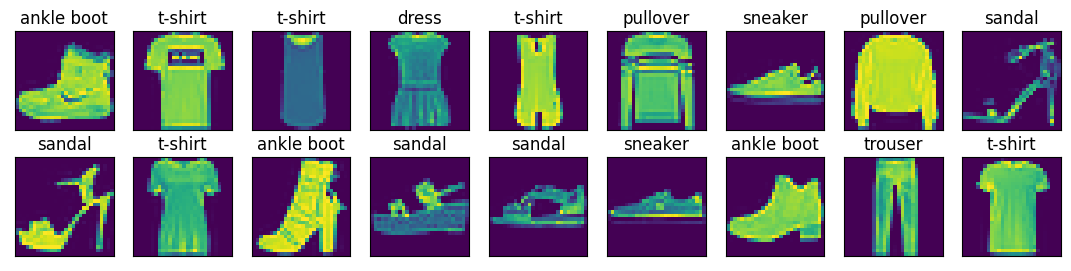

In [4]:
# 根据数字标签获得文字标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in labels]
# 展示数据图像
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    figsize = (num_cols*scale,num_rows*scale)
    plt.figure(figsize=figsize)
    axes = []
    for i in range(num_rows*num_cols):
        axi = plt.subplot(num_rows,num_cols,i+1)
        axes.append(axi)
    for i, (ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));


# 模型训练

In [5]:
# d2l中的函数，需要替换
import numpy as np
import time

class Accumulator: 
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n
        print(self.data)

    def add(self, *args):
        for a, b in zip(self.data, args):   # 分别输出一下a,b
            print(a, b)

        self.data = [a + float(b) for a, b in zip(self.data, args)]
        print(self.data)

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    

class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')

        self.fig = figsize
        self.axes = []
        for i in range(nrows*ncols):
            axi = plt.subplot(nrows,ncols,i+1)
            self.axes.append(axi)

        # if nrows * ncols == 1:
        #     self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
            """设置matplotlib的轴。"""
            axes.set_xlabel(xlabel)
            axes.set_ylabel(ylabel)
            axes.set_xscale(xscale)
            axes.set_yscale(yscale)
            axes.set_xlim(xlim)
            axes.set_ylim(ylim)
            if legend:
                axes.legend(legend)
            axes.grid()

        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts





    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        """Defined in :numref:`sec_minibatch_sgd`"""
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


In [3]:
# 获得dataLoader
batch_size = 256
train_loader = data.DataLoader(mnist_train,batch_size,shuffle = True, num_workers = 4)    
test_loader  = data.DataLoader(mnist_test,batch_size,shuffle = False, num_workers = 4)    


argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)


def accuracy(y_hat, y):
    """Compute the number of correct predictions.

    Defined in :numref:`sec_utils`"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = argmax(y_hat, axis=1)
    cmp = astype(y_hat, y.dtype) == y
    return float(reduce_sum(astype(cmp, y.dtype)))

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_utils`"""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]

def train(net,train_iter,test_iter, num_epochs,lr,device):
    # 初始化采用xavier初始化
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)

    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.460, train acc 0.828, test acc 0.794
32870.7 examples/sec on cuda


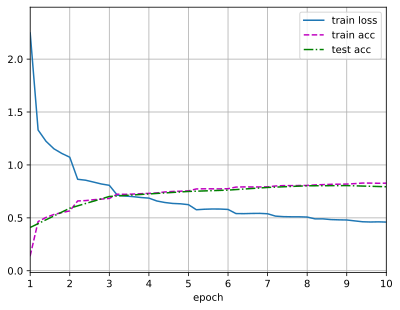

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr, num_epochs = 0.9, 10
train(Lenet, train_loader, test_loader, num_epochs, lr, device)

# 模型训练(自己写的版本)

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils import data
from torchvision import transforms
from torch import nn
import wandb

wandb.init(
    # set the wandb project where this run will be logged
    project="LeNet",
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.9,
    "architecture": "Lenet",
    "dataset": "Fashion-Mnist",
    "epochs": 10,
    }
)
class Lenet(nn.Module):
    def __init__(self):
        super(Lenet,self).__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size= 5,padding=2)
        self.avg_pooling1 = nn.AvgPool2d(2,2)
        
        self.conv2 = nn.Conv2d(6,16,kernel_size= 5)
        self.avg_pooling2 = nn.AvgPool2d(2,2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(16*5*5,120)
        self.dense2 = nn.Linear(120,84)
        self.dense3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.avg_pooling1(x)

        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.avg_pooling2(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = torch.sigmoid(x)
        x = self.dense2(x)
        x = torch.sigmoid(x)
        x = self.dense3(x)

        return x 
    
net = Lenet()
print(net)
for param in net.parameters():
    print(type(param.data),param.size())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 1343325715 (bjtuei). Use `wandb login --relogin` to force relogin


Lenet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avg_pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avg_pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=400, out_features=120, bias=True)
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense3): Linear(in_features=84, out_features=10, bias=True)
)
<class 'torch.Tensor'> torch.Size([6, 1, 5, 5])
<class 'torch.Tensor'> torch.Size([6])
<class 'torch.Tensor'> torch.Size([16, 6, 5, 5])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([120, 400])
<class 'torch.Tensor'> torch.Size([120])
<class 'torch.Tensor'> torch.Size([84, 120])
<class 'torch.Tensor'> torch.Size([84])
<class 'torch.Tensor'> torch.Size([10, 84])
<class 'torch.Tensor'> torch.Size([10])


In [2]:
# 超参数
batch_size = 256
lr = 0.9
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.SGD(net.parameters(),lr)
loss = nn.CrossEntropyLoss()
net.to(device)

trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root = '../../../../AI/DataSets/',train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root = '../../../../AI/DataSets/',train=False,transform=trans,download=True)
train_dataLoder = data.DataLoader(mnist_train,batch_size)
test_dataLoader = data.DataLoader(mnist_test)
text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']


def test(net, device, test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    # with torch.no_grad() 在此代码块中所有tensor的requires_grad都设为了False
    with torch.no_grad():
        for X, y in test_loader:
            # Load the input features and labels from the test dataset
            X, y = X.to(device), y.to(device)
            y_hat = net(X)        
            # 交叉熵损失
            test_loss += F.cross_entropy(y_hat, y, reduction='sum').item()
            # Get the index of the max log-probability
            pred = torch.argmax(y_hat,dim = 1)
            correct += pred.eq(y.view_as(pred)).sum().item()
    return test_loss/(len(test_loader.dataset)), correct/(len(test_loader.dataset))
    

def train(net,device,train_loader,optimizer,num_epochs):
    # 参数初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.train()
    net.to(device)
    print('Training start:')

    for epoch in range(num_epochs):
        num_correct = 0
        train_loss = 0
        for batch_idx,(X,y) in enumerate(train_loader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            pred = torch.argmax(y_hat,dim=1)
            num_correct += torch.eq(pred,y).sum().float().item()
            l = loss(y_hat,y)
            l.backward()
            # optimizer进行一次参数更新
            optimizer.step()
            # l是tensor类型，取值需要.item()
            train_loss += l.item()

        train_acc = num_correct/len(train_loader.dataset)
        train_loss = train_loss / (len(train_loader.dataset) / batch_size)
        test_loss, test_acc = test(net, device,test_dataLoader) 
        print('Epoch {} training accuracy:{:.4f}, training loss{:.4f}'.format(epoch,train_acc,train_loss))
        wandb.log({
        "Epoch": epoch,
        "Train Loss":train_loss,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Test Loss": test_loss})
    wandb.finish()

train(net,device,train_dataLoder,optimizer,num_epochs)


Training start:
Epoch 0 training accuracy:0.1020, training loss2.3217
Epoch 1 training accuracy:0.4387, training loss1.4480
Epoch 2 training accuracy:0.6553, training loss0.8653
Epoch 3 training accuracy:0.7209, training loss0.7155
Epoch 4 training accuracy:0.7514, training loss0.6406
Epoch 5 training accuracy:0.7725, training loss0.5892
Epoch 6 training accuracy:0.7892, training loss0.5464
Epoch 7 training accuracy:0.8044, training loss0.5132
Epoch 8 training accuracy:0.8161, training loss0.4875
Epoch 9 training accuracy:0.8262, training loss0.4670


Epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,▁▆▇▇▇█████
Test Loss,█▃▂▂▂▁▁▁▁▁
Train Accuracy,▁▄▆▇▇▇████
Train Loss,█▅▃▂▂▁▁▁▁▁
Epoch,9
Test Accuracy,0.8169
Test Loss,0.49833
Train Accuracy,0.82617
Train Loss,0.46695
